In [1]:
using StatsPlots
using CSV, DataFrames
using Distributions
using Turing 
using StatsBase
using StatisticalRethinking

In [32]:
# Code 5.1
d = CSV.File(joinpath("data","WaffleDivorce.csv")) |> DataFrame;
describe(d)

d.D = standardize(ZScoreTransform, d.Divorce, dims =1) # ZScore transfomration scales and centers the vector with μ = 0 and σ = 1
d.M = standardize(ZScoreTransform, d.Marriage, dims =1)
d.A = standardize(ZScoreTransform, d.MedianAgeMarriage, dims =1)
describe(d)

,variable,mean,min,median,max,nmissing,eltype
,Symbol,Union…,Any,Union…,Any,Int64,DataType
1,Location,,Alabama,,Wyoming,0,String
2,Loc,,AK,,WY,0,String
3,Population,6.1196,0.56,4.435,37.25,0,Float64
4,MedianAgeMarriage,26.054,23.2,25.9,29.7,0,Float64
5,Marriage,20.114,13.5,19.7,30.7,0,Float64
6,Marriage SE,1.3994,0.39,1.185,3.92,0,Float64
7,Divorce,9.688,6.1,9.75,13.5,0,Float64
8,Divorce SE,0.9618,0.24,0.795,2.5,0,Float64
9,WaffleHouses,32.34,0,1.0,381,0,Int64


In [65]:
# Code 5.3

@model m5_1(divorce_rate, median_age) = begin 
    α  ~ Normal(0,0.2)
    βₐ ~ Normal(0,0.5)
    μ  = α .+ βₐ .* median_age 
    σ ~ Exponential(1)
    divorce_rate ~ MvNormal(μ, σ)
end

m5_1 (generic function with 1 method)

In [39]:
priors_5_1 = sample(m5_1(d.D,d.A), Prior(),50) |> DataFrame

,α,βₐ,σ
,Float64,Float64,Float64
1,-0.152444,0.38651,0.0758594
2,-0.267766,-0.286348,0.545554
3,0.14545,0.473775,1.44946
4,0.429913,-0.113554,0.837873
5,-0.0874606,0.530129,3.22464
6,-0.226779,-0.337073,0.402467
7,0.0435625,-0.625271,2.1641
8,0.00910887,-0.974152,0.262208
9,0.323482,0.505343,0.632848


In [43]:
describe(priors_5_1)

,variable,mean,min,median,max,nmissing,eltype
,Symbol,Float64,Float64,Float64,Float64,Int64,DataType
1,α,0.0320708,-0.548115,0.0181969,0.43014,0,Float64
2,βₐ,-0.0671994,-1.29557,-0.139254,1.02249,0,Float64
3,σ,0.913398,0.0120114,0.613122,3.31158,0,Float64


Prior Simulation
---

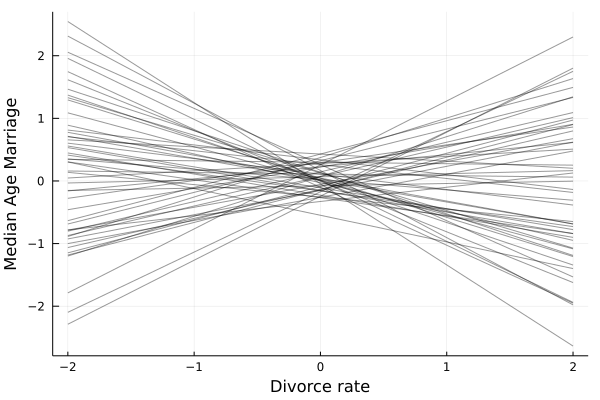

In [58]:
x = -2:0.1:2
plot()
for r in eachrow(priors_5_1)
    p = lin(r.α, x, r.βₐ)
    plot!(x, p, color = :black, alpha = 0.4)
end
plot!(legend = false)
plot!(xlabel = "Divorce rate", ylabel = "Median Age Marriage")

Posterior Predictions
---

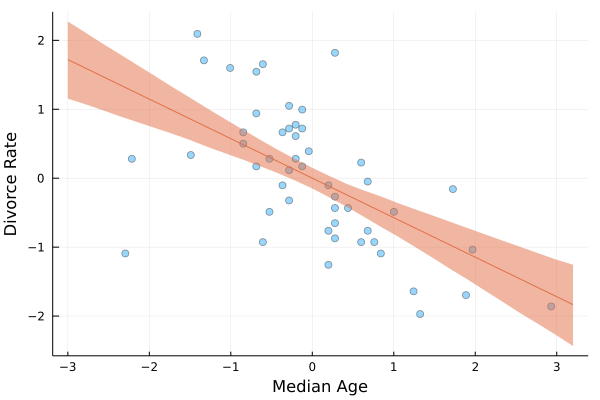

In [70]:
q5_1 = StatisticalRethinking.quap(m5_1(d.D,d.A))
post = DataFrame(rand(q5_1.distr, 1000)', q5_1.params)

A_seq = range(-3, 3.2, length = 30)
mu = lin(post.α', A_seq, post.βₐ') |> meanlowerupper

scatter(d.A, d.D, alpha = 0.4, legend = false)
plot!(A_seq, mu.mean, ribbon = (mu.mean .- mu.lower, mu.upper .- mu.mean), xlabel="Median Age", ylabel="Divorce Rate")

In [79]:
@model m5_2(divorce_rate, M) = begin 
    α  ~ Normal(0,0.2)
    βₘ ~ Normal(0,0.5)
    μ  = α .+ βₘ .* M 
    σ ~ Exponential(1)
    divorce_rate ~ MvNormal(μ, σ)
end

priors_5_2 = sample(m5_2(d.D,d.M), Prior(),50) |> DataFrame;

In [88]:
m5_2_Mt = m5_2(d.D, d.M)
	quap5_2_Mt = quap(m5_2_Mt);

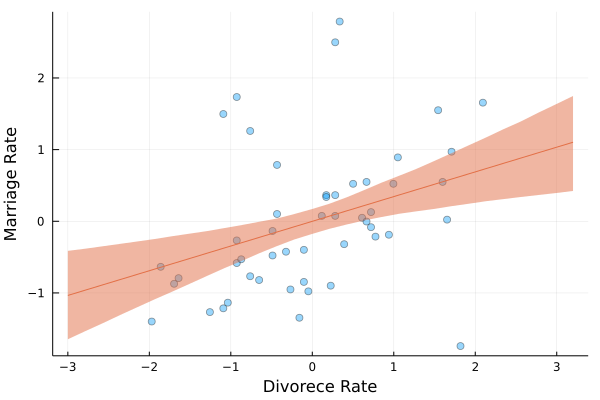

In [89]:
dfa5_2_Mt = DataFrame(rand(quap5_2_Mt.distr, 1000)', quap5_2_Mt.params)
	M_seq = range(-3, 3.2, length = 30)
	mu5_2_Mt = lin(dfa5_2_Mt.α', M_seq, dfa5_2_Mt.βₘ') |> meanlowerupper
	scatter(d.D, d.M, alpha = 0.4, legend = false)
	plot!(M_seq, mu5_2_Mt.mean, ribbon = 
		(mu5_2_Mt.mean .- mu5_2_Mt.lower, mu5_2_Mt.upper .- mu5_2_Mt.mean), xlabel="Divorece Rate", ylabel="Marriage Rate")